# Logistic Regression for real data

This time we used data without removing consecutive rows with the same value of Mid-Price Indicator.

The results are much much worse.

In [47]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import linear_model
from sklearn import svm
from scipy import stats

from mlxtend.plotting import plot_decision_regions

from ast import literal_eval

import warnings

from collections import OrderedDict

from lob_data_utils import lob, model, roc_results, gdf_pca, lob_classify, stocks
from lob_data_utils.svm_calculation import lob_svm

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
data_dir = 'data/prepared'
should_savefig = False

In [49]:
choosen_stocks = pd.read_csv('choosen_stocks.csv').values[:, 1]
df_stocks = pd.read_csv('stocks.csv')
df_res = pd.read_csv('res_log_que.csv')
df_res = pd.merge(df_res, df_stocks, on='stock')
columns = ['stock', 'is_choosen', 'mid_price_indicator_ratio'] + [
    c for c in df_res.columns if 'matt' in c or 'roc' in c]
df_res.columns

Index(['Unnamed: 0_x', 'f1', 'kappa', 'kernel', 'matthews', 'precision',
       'recall', 'roc_auc', 'stock', 'test_f1', 'test_kappa', 'test_matthews',
       'test_precision', 'test_recall', 'test_roc_auc', 'train_f1',
       'train_kappa', 'train_matthews', 'train_precision', 'train_recall',
       'train_roc_auc', 'train_val_f1', 'train_val_kappa',
       'train_val_matthews', 'train_val_precision', 'train_val_recall',
       'train_val_roc_auc', 'Unnamed: 0_y', 'mean_mid_price', 'mean_spread',
       'mid_price_indicator_ratio', 'test_length', 'test_mean_mid_price',
       'test_mean_spread', 'test_mid_price_indicator_ratio', 'train_length',
       'diff_mean_mid_price', 'diff_mid_price_indicator_ratio',
       'diff_mean_spread', 'km', 'is_choosen'],
      dtype='object')

### Columns

Scores: f1, kappa, roc auc, matthews, recall, precision for test, val (without indicator f.e. `matthews`), train during validation (`train_val`), train.

Mean mid price and mean spread for test and training set (we need to know these to know if testing set has similar distribution):
`mean_mid_price`, `mean_spread`, `test_mean_mid_price`, `test_mean_spread`

differences between training and testing set:
`diff_mean_mid_price`, `diff_mid_price_indicator_ratio` `diff_mean_spread`

Lengths of training and testing set (not important):
`train_length`, `test_length`

The ratio between number of postivies and negatives for training and testing set:
`mid_price_indicator_ratio` and `test_mid_price_indicator_ratio`

Cluster to which stock belongs (clustered using mean mid price and mean spread), there are 3 clusters: `km`
If we pick it for further calculations (5 per cluster): `is_choosen` 

In [32]:
print('mcc', len(df_res[df_res['matthews'] > 0.0][columns]), 'per', len(df_res['stock'].unique()))
print('roc_auc', len(df_res[df_res['roc_auc'] > 0.5][columns]), 'per', len(df_res['stock'].unique()))
df_res[df_res['matthews'] > 0.0][columns]

mcc 18 per 98
roc_auc 18 per 98


,stock,is_choosen,mid_price_indicator_ratio,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,train_val_matthews,train_val_roc_auc
0,9269,0,0.671214,0.028616,0.510409,0.077783,0.517000,0.046449,0.511867,0.053389,0.516710
4,10166,0,0.685265,0.021292,0.505150,0.000000,0.500000,0.019192,0.500309,0.029496,0.506158
6,12059,0,0.655184,0.022822,0.503132,0.064470,0.509790,0.047270,0.509657,0.018077,0.502687
17,1388,0,0.633789,0.057383,0.520920,0.094821,0.529242,0.074098,0.522765,0.086434,0.527414
19,9069,0,0.781648,0.114785,0.548381,0.086312,0.532917,0.100779,0.543831,0.100677,0.545483
21,9094,0,0.630165,0.071233,0.520615,0.102270,0.531999,0.100598,0.532428,0.084166,0.524812
25,9063,0,0.749912,0.086896,0.533042,0.074558,0.523182,0.077907,0.526811,0.086749,0.531786
29,9062,1,0.814060,0.063329,0.523717,0.037227,0.512758,0.066396,0.524623,0.070908,0.526737
41,11583,1,0.562766,0.007564,0.500747,0.000000,0.500000,0.000000,0.500000,0.005080,0.500462
48,9074,0,0.588410,0.023874,0.503880,0.000000,0.500000,0.000000,0.500000,0.013105,0.502125


For only 18/98 stocks the MCC validation score was above 0 (which means that predictions were any good...). For ROC area validation score same ratio 18/98 for stocks for stocks with score above 0.5.

In [20]:
df_res[df_res['stock'].isin(choosen_stocks)][columns].sort_values(by='mid_price_indicator_ratio')

,stock,is_choosen,mid_price_indicator_ratio,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,train_val_matthews,train_val_roc_auc
52,11869,1,0.372354,0.000000,0.500000,0.000000,0.500000,0.000000,0.500000,0.000000,0.500000
28,4799,1,0.375902,0.000000,0.500000,0.000000,0.500000,0.000000,0.500000,0.000000,0.500000
49,12255,1,0.382685,0.000000,0.500000,0.000000,0.500000,0.000000,0.500000,0.000000,0.500000
23,4549,1,0.409391,0.000000,0.500000,0.000000,0.500000,0.000000,0.500000,0.000000,0.500000
11,9761,1,0.421796,0.000000,0.500000,0.000000,0.500000,0.000000,0.500000,0.000000,0.500000
33,9268,1,0.443725,0.000000,0.500000,0.000000,0.500000,0.000000,0.500000,0.000000,0.500000
45,4320,1,0.449657,-0.005726,0.499619,0.000000,0.500000,0.000000,0.500000,0.011002,0.500612
32,11583,1,0.562766,0.007564,0.500747,0.000000,0.500000,0.000000,0.500000,0.005080,0.500462
31,9058,1,0.666443,0.000000,0.500000,0.000000,0.500000,0.000000,0.500000,0.000000,0.500000
6,9061,1,0.762971,0.056130,0.519736,0.028219,0.506652,0.028341,0.507250,0.055184,0.518238


Above there are results for stocks we have choosen by performing clustering. We can observe that for only the stocks for which we have balanced classes (`mid_price_indicator_ratio` - is equal to 1 if the classes are perfectly balanced) have any results better than coin toss.

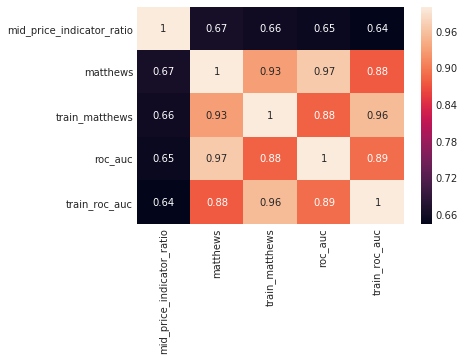

In [37]:
sns.heatmap(
    df_res[['mid_price_indicator_ratio', 'matthews', 'train_matthews', 'roc_auc', 'train_roc_auc']].corr(), 
    annot=True)

The scores we obtained are highly correlated with `mid_price_indicator_ratio`...

Logistic Regression does not work well if the classes are imbalanced.

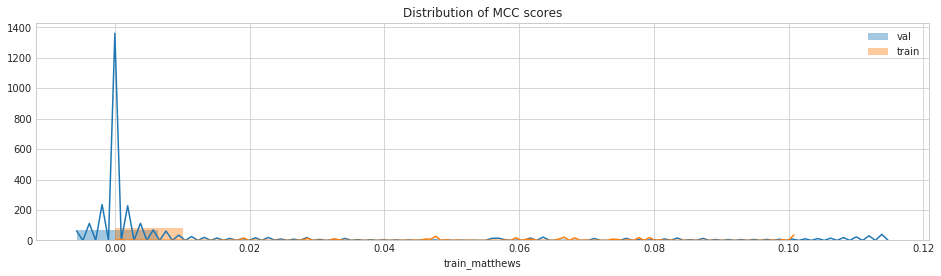

In [43]:
plt.figure(figsize=(16, 4))
sns.distplot(df_res['matthews'], label='val')
sns.distplot(df_res['train_matthews'], label='train')
plt.title('Distribution of MCC scores')
plt.legend()

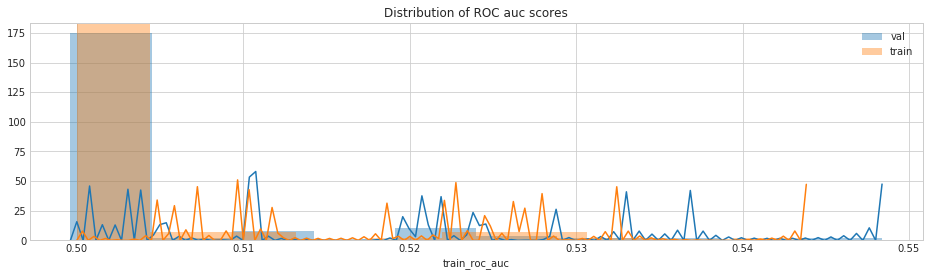

In [46]:
plt.figure(figsize=(16, 4))
sns.distplot(df_res['roc_auc'], label='val')
sns.distplot(df_res['train_roc_auc'], label='train')
plt.title('Distribution of ROC auc scores')
plt.legend()

## Conclusion

Now we have reasonable argument why this approach is not suitable anymore. In short:
bad results. Of course there is a way to avoid that: [Logistic Regression in Rare
Events Data](https://gking.harvard.edu/files/gking/files/0s.pdf)
but lets not go there.